In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import requests
import json

state_lockdown_file = pd.read_csv("data_sources/lockdown_us.csv")
state_deaths_cases_file = pd.read_csv("data_sources/liz-friedman-us-covid-19-data-from-nytimes/us-states.csv")


In [28]:
url = "https://api.covidtracking.com/v1/states/current.json"
state_current_data = (requests.get(url)).json()
state_current_data=pd.DataFrame(state_current_data)
state_current_data.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200825,AK,5666,328165,NaN,46.0,NaN,NaN,NaN,6.0,...,333831,4,0,bd407e9ed01cce1ea303fe93d06cd759e6488332,0,0,0,0,0,
1,20200825,AL,117242,810035,NaN,1097.0,13793.0,NaN,1399.0,NaN,...,927277,13,0,4945c5836682d749c8ab2609d9b6dce0b72b60ce,0,0,0,0,0,
2,20200825,AR,57374,616810,NaN,442.0,4013.0,NaN,NaN,108.0,...,674184,15,51,28ac380c04825ab6eeea101cae059962bda243bb,0,0,0,0,0,
3,20200825,AS,0,1514,NaN,NaN,NaN,NaN,NaN,NaN,...,1514,0,0,e762458f6ad93db951259394cf32880309d5dfc4,0,0,0,0,0,
4,20200825,AZ,199273,962931,NaN,999.0,21365.0,319.0,NaN,168.0,...,1162204,21,146,df43531eadb8a5893d2c552b4285f1b00e483345,0,0,0,0,0,


In [42]:
state_deaths_cases_file.head()
state_deaths_cases_file = state_deaths_cases_file.rename(columns={"state":"State"})
state_deaths_cases_file = state_deaths_cases_file.sort_values("State")
state_deaths_cases_file


,date,fips,cases,deaths
State,,,,
Alabama,2020-04-24,1,6026,209
Alabama,2020-04-30,1,7068,272
Alabama,2020-07-26,1,79294,1473
Alabama,2020-08-23,1,115060,2013
Alabama,2020-07-25,1,78130,1456
...,...,...,...,...
Wyoming,2020-05-22,56,803,12
Wyoming,2020-07-02,56,1550,20
Wyoming,2020-05-11,56,669,7


In [46]:
state_deaths_cases_file = state_deaths_cases_file.dropna()
state_deaths_cases_file

,date,fips,cases,deaths
State,,,,
Alabama,2020-04-24,1,6026,209
Alabama,2020-04-30,1,7068,272
Alabama,2020-07-26,1,79294,1473
Alabama,2020-08-23,1,115060,2013
Alabama,2020-07-25,1,78130,1456
...,...,...,...,...
Wyoming,2020-05-22,56,803,12
Wyoming,2020-07-02,56,1550,20
Wyoming,2020-05-11,56,669,7


In [52]:
state_deaths_cases_file = state_deaths_cases_file.loc[["Arizona","Florida","Kansas",
                                                       "New York","Washington","Wisconsin"],["date","deaths"]]


In [58]:
ks_data = state_deaths_cases_file.loc[["Kansas"],["date","deaths"]]
ks_data.sort_values("deaths")

,date,deaths
State,,
Kansas,2020-03-11,0
Kansas,2020-03-07,0
Kansas,2020-03-09,0
Kansas,2020-03-08,0
Kansas,2020-03-10,0
...,...,...
Kansas,2020-08-19,420
Kansas,2020-08-20,423
Kansas,2020-08-21,430


In [30]:
state_lockdown_file[pd.isnull(state_lockdown_file['County'])]
state_lockdown_file[pd.isnull(state_lockdown_file['Type'])]
state_lockdown_file.head()

,Country,State,County,Date,Type
0,United States,Alabama,NaN,2020-04-04,Stay at home
1,United States,Alabama,Birmingham,2020-03-24,Shelter in place
2,United States,Alaska,NaN,2020-03-28,Stay at home
3,United States,Arizona,NaN,2020-03-31,Stay at home
4,United States,California,NaN,2020-03-19,Stay at home


In [31]:
state_current_narrow = state_current_data[["state","positive","death","hospitalized"]]
state_current_drop = state_current_narrow.dropna()
state_current_drop
state_current_drop = state_current_drop.set_index('state')
state_current_drop

,positive,death,hospitalized
state,,,
AL,117242,2037,13793.0
AR,57374,711,4013.0
AZ,199273,4792,21365.0
CO,55341,1824,6845.0
CT,52040,4463,11087.0
FL,605502,10717,37477.0
GA,258354,5262,23717.0
HI,6984,49,419.0
ID,30070,314,1269.0


In [43]:
special_states_data = state_current_drop.loc[["AZ","FL","KS","NY","WA","WI"],["death","hospitalized"]]
special_states_data


,death,hospitalized
state,,
AZ,4792,21365.0
FL,10717,37477.0
KS,426,2183.0
NY,25297,89995.0
WA,1867,6542.0
WI,1102,5610.0


Text(0.5, 1.0, 'Comparing States by Deaths and Hospitalizations Due to COVID-19')

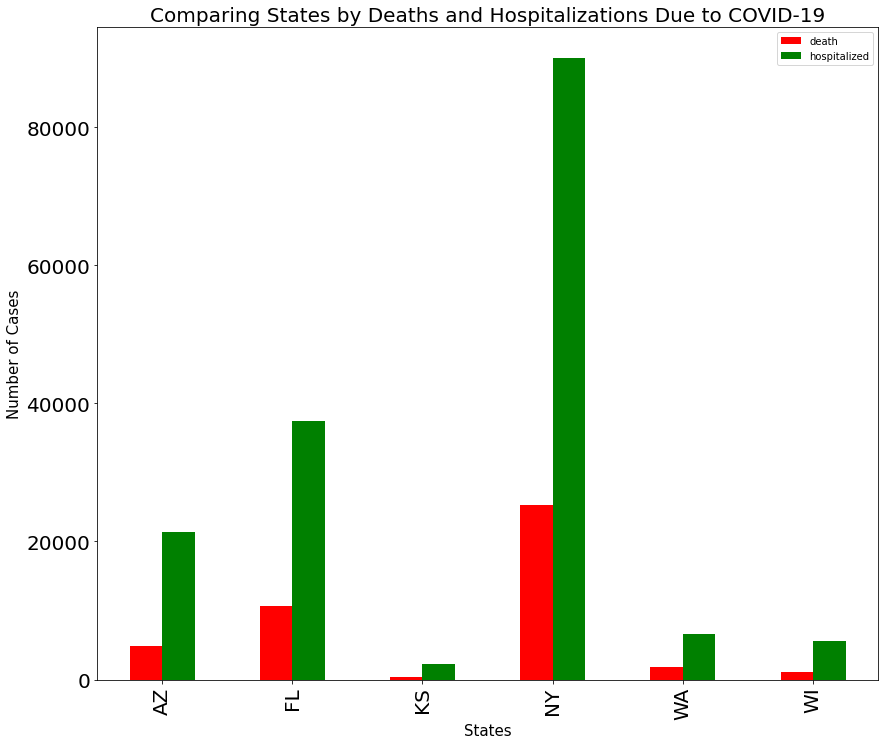

In [44]:
my_colors = "rgbkymc"
plot_pandas = special_states_data.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to COVID-19", fontsize=20)

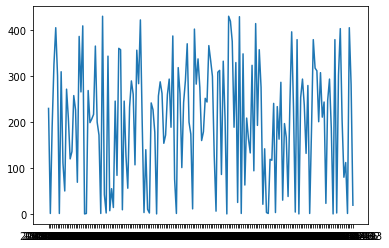

In [56]:
plt.plot(ks_data["date"],ks_data["deaths"])